In [3]:
#from google.colab import drive
#drive.mount("/content/drive")

In [4]:
import pandas as pd
import numpy as np
import random
from scipy.io.arff import loadarff
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

import torchvision
from torchvision import transforms

from sklearn.model_selection import KFold
from sklearn.metrics import *

In [5]:
if torch.backends.mps.is_available(): device ='mps' 
else: device='cpu'
#if torch.cuda.is_available(): device='cuda:0'
#else: device = 'cpu'
device

'mps'

In [6]:
CRICKET_X = 'CricketX'
INSECT_WINGBEAT_SOUND = 'InsectWingbeatSound'
U_WAVE_GESTURE_LIBRARY_ALL = 'UWaveGestureLibraryAll'
#EPILEPRIC_SEIZURE= 'EpilepticSeizure'
#MFPT = 'MFPT'
#XJTU = 'XJTU'

In [7]:
batch_size = 128
num_features = 64
num_epochs = 1000
patience = 200 # num of epochs with prev_loss - loss <= threshold without stopping
learning_rate = 0.01
alpha = 0.4 #past-future segment split ratio

K=8
Kfolder = KFold(n_splits = K, shuffle = True)

TODO

In [8]:
# def magnitude_warp_s(x, sigma=0.2, knot=4, plot=False):

#     print(f'x.shape: {x.shape}')
#     print(f'x: {x}')
#     print(f'np.ones((x.shape[1], 1)).shape: {np.ones((x.shape[1], 1)).shape}')
#     print(f'np.ones((x.shape[1], 1)): {np.ones((x.shape[1], 1))}')
#     print(f'np.linspace(0, x.shape[0] - 1., num=knot + 2)).shape: {np.linspace(0, x.shape[0] - 1., num=knot + 2).shape}')
#     print(f'np.linspace(0, x.shape[0] - 1., num=knot + 2)): {np.linspace(0, x.shape[0] - 1., num=knot + 2)}')

#     from scipy.interpolate import CubicSpline
#     orig_steps = np.arange(x.shape[0])

#     random_warps = np.random.normal(loc=1.0, scale=sigma, size=(1, knot + 2, x.shape[1]))
#     warp_steps = (np.ones((x.shape[1], 1)) * (np.linspace(0, x.shape[0] - 1., num=knot + 2))).T

#     print(f'warp_steps: {warp_steps}')

#     li = []
#     for dim in range(x.shape[1]):
#         li.append(CubicSpline(warp_steps[:, dim], random_warps[0, :, dim])(orig_steps))
#     warper = np.array(li).T

#     x_ = x * warper

#     #if plot:
#     #    hlp.plot1d(x, x_, save_file='aug_examples/magnitude_warp_s.png')
    
#     return x_


# def time_warp_s(x, sigma=0.2, knot=4, plot=False):
#     from scipy.interpolate import CubicSpline
#     orig_steps = np.arange(x.shape[0])

#     random_warps = np.random.normal(loc=1.0, scale=sigma, size=(1, knot + 2, x.shape[1]))
#     warp_steps = (np.ones((x.shape[1], 1)) * (np.linspace(0, x.shape[0] - 1., num=knot + 2))).T

#     ret = np.zeros_like(x)
#     for dim in range(x.shape[1]):
#         time_warp = CubicSpline(warp_steps[:, dim],
#                                 warp_steps[:, dim] * random_warps[0, :, dim])(orig_steps)
#         scale = (x.shape[0] - 1) / time_warp[-1]
#         ret[:, dim] = np.interp(orig_steps, np.clip(scale * time_warp, 0, x.shape[0] - 1),
#                                    x[:, dim]).T
#     #if plot:
#     #    hlp.plot1d(x, ret, save_file='aug_examples/time_warp_s.png')
    
#     return ret


# class MagnitudeWrap:
#     def __init__(self, sigma, knot, p):
#         self.sigma = sigma
#         self.knot = knot
#         self.p = p

#     def __call__(self, data):
#         print('### MagnitudeWrap')

#         if random.random() < self.p:
#             return self.forward(data)

#         return data

#     def forward(self, data):
#         return magnitude_warp_s(data, sigma=self.sigma, knot=self.knot)


# class TimeWarp:
#     def __init__(self, sigma, knot, p):
#         self.sigma = sigma
#         self.knot = knot
#         self.p = p

#     def __call__(self, data):
#         print('### TimeeWrap')

#         if random.random() < self.p:
#             return self.forward(data)

#         return data

#     def forward(self, data):
#         return time_warp_s(data, sigma=self.sigma, knot=self.knot)

<div style="background-color: rgb(0, 255, 255, 0.2);"><h5>class LabeledDataset()</h5></div>


Class for labeled dataset. 

Takes: 
- dataframe: pandas dataframe of dataset

Methods:
- len: returns the length of dataframe
- getitem: returns the pair (feature, tarhet) of sample at index 'idx' of dataframe

In [9]:
class LabeledDataset(Dataset):
    def __init__(self, dataframe=None):

        self.df = dataframe

        #self.magnitude_warp = MagnitudeWrap(sigma=0.3, knot=4, p=0.3)
        #self.time_warp = TimeWarp(sigma=0.2, knot=8, p=0.3)
        #self.transform = transform = transforms.Compose([self.magnitude_warp, self.time_warp])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        self.target = torch.from_numpy(np.array(self.df['target'][idx])).to(torch.int64)
        self.features = torch.from_numpy(np.array(self.df.iloc[idx:idx+1, :len(self.df.columns)-1])).to(torch.float32)

        #self.features = self.transform(self.features)

        return  self.features, self.target

<div style="background-color: rgb(0, 255, 255, 0.2);"><h5>class UnlabeledDataset()</h5></div>

Class for unlabeled dataset. 

Takes: 
- df_past: pandas dataframe of past segments
- df_pos: pandas dataframe of future segments in positive relation with past segments
- df_neg: pansas dataframe of future segments in negative relation with past segments

Methods:
- len: returns the length of dataframe (df_past, df_pos and df_neg have same length) 
- getitem: returns three samples, each at index 'idx' of df_past, df_pos and df_neg 

In [10]:
class UnlabeledDataset(Dataset):
    def __init__(self, df_past=None, df_future=None):

        self.df_past = df_past
        self.df_future = df_future

        #self.magnitude_warp = MagnitudeWrap(sigma=0.3, knot=4, p=0.3)
        #self.time_warp = TimeWarp(sigma=0.2, knot=8, p=0.3)
        #self.transform = transform = transforms.Compose([self.magnitude_warp, self.time_warp])

    def __len__(self):
        return len(self.df_past) # len is the same for all df

    def __getitem__(self, idx):
        self.features_past = torch.from_numpy(np.array(self.df_past.iloc[idx:idx+1,:])).to(torch.float32)
        self.features_future = torch.from_numpy(np.array(self.df_future.iloc[idx:idx+1,:])).to(torch.float32)

        #self.features = self.transform(self.features)

        return  self.features_past, self.features_future

<div style="background-color: rgb(0, 255, 255, 0.2);"><h5>class BackboneEncoder()</h5></div>

Implementation of Backbone Encoder model. This model is used for features extraction of samples.

Takes: 
- num_features: number of features in output by BackboneEncoder

Input:
- tensor of shape [batch_size, 1, num_samples]

Output:
- tensor of shape [batch_size, num_features]

In [11]:
class BackboneEncoder(nn.Module):
    def __init__(self, num_features=None):
        super().__init__()
        self.num_features = num_features

        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(num_features=8),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(num_features=self.num_features),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=1)
        )

        self.flatten = nn.Flatten()

        
    def forward(self, x):
        
        x = x.view(x.shape[0], 1, -1) # shape = (batch_size, 1, num_col)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.flatten(x)
        x = F.normalize(x, dim=1)
        
        return x

<div style="background-color: rgb(0, 255, 255, 0.2);"><h5>class ClassificationHead()</h5></div>

Implementation of Classification Head model. This model is used for multiclass classification samples in labeled dataset. Is lies after the Backbone Encoder, which has [batch_size, num_features] as output shape.

Takes: 
- num_features: number of features in output by BackboneEncoder

Input:
- tensor of shape [batch_size, num_features]

Output:
- tensor of shape [batch_size, num_classes]

In [12]:
class ClassificationHead(nn.Module):
    def __init__(self, num_features=None, num_classes=None):
        super().__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        #self.fc = nn.Linear(self.num_features, self.num_classes)

        self.fc1 = nn.Linear(self.num_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.leakyReLU = nn.LeakyReLU()
        self.fc2 = nn.Linear(256, self.num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leakyReLU(x)
        x = self.fc2(x)
        return x
        #return self.fc(x)

<div style="background-color: rgb(0, 255, 255, 0.2);"><h5>class RelationHead()</h5></div>

Implementation of Relation Head model. This model is used for binary classification of relation between past-future segments. Is lies after the Backbone Encoder, which has [batch_size, num_features] as output shape.

Takes: 
- num_features: number of features in output by BackboneEncoder

Input:
- tensor of shape [batch_size, num_features]

Output:
- tensor of shape [batch_size, 1]

In [13]:
class RelationHead(nn.Module):
    def __init__(self, num_features=None):
        super().__init__()
        self.num_features = num_features
        self.fc1 = nn.Linear(2*self.num_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.leakyReLU = nn.LeakyReLU()
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leakyReLU(x)
        x = self.fc2(x)
        
        return x

<div style="background-color: rgb(0, 255, 255, 0.2);"><h5>class EarlyStopping()</h5></div>

Implementation of early stopping technique.

Takes: 
- patience: number of epochs with abs(prev_loss-loss) <= threshold without stopping, where 'prev_loss' is the loss recordered in the previous epoch and 'loss' is the loss computed in the current epoch
- threshold: below this number there isn't learning between previous epoch and current epoch

Returns:
- True: if the counter has reached the number 'patience'
- False: otherwise

Method:
- init: initializes counter=0 and prev_loss=0
- check: checks if 'counter' has reached the number 'patience' or update it.

In [14]:
class EarlyStopping():
    def __init__(self, patience=None):
        super().__init__()
        self.patience=patience #number of epochs with loss>=min_loss without stopping
        self.counter=1 #counter of epochs with abs(min_loss-loss) <= threshold
        self.min_loss=0 #loss of previous epoch
        self.min_epoch=1
        self.stop = False

    def __restart__(self):
        self.counter=1
        self.min_loss=0
        self.min_epoch=1
        self.stop=False
        return

    def __check__(self, loss=None, epoch=None):

        if self.counter==1:
            self.min_loss=loss
            self.min_epoch=epoch
            self.counter+=1
            self.stop=False
            return self.counter, self.stop, self.min_loss, self.min_epoch

        elif self.counter==patience: 
            self.stop=True
            return self.counter, self.stop, self.min_loss, self.min_epoch

        else:   
            if loss >= self.min_loss: 
                self.counter+=1
                self.stop=False
            else:
                self.min_loss=loss
                self.min_epoch=epoch
                self.counter=1
                self.stop=False

            return self.counter, self.stop, self.min_loss, self.min_epoch

<div style="background-color: rgb(102, 204, 0, 0.2);"><h5>def accuracy()</h5></div>

Implements accuracy metrics, relying on torchmetrics.Accuracy and torchmetrics.classification.BinaryAccuracy methods.

Takes: 
- predictions: predictions makes by model
- targets: labels of samples in dataset
- num_classes: number of classes of dataset

Returns:
- accuracy score

In [15]:
def accuracy(predictions=None, targets=None, task=None):
    
    if task == 'multiclass':

        preds_softmax = torch.log_softmax(predictions, dim=1)
        _, preds =  torch.max(preds_softmax, dim=1)
        correct_preds = (preds == targets).float()
        accuracy = correct_preds.sum()/len(correct_preds)

        return accuracy.item()

    elif task == 'binary':

        preds_sigmoid = torch.round(torch.sigmoid(predictions))
        correct_preds = (preds_sigmoid == targets).float()
        accuracy = correct_preds.sum()/len(correct_preds)

        return accuracy.item()

<div style="background-color: rgb(102, 204, 0, 0.2);"><h5>def load_labeledDataframe()</h5></div>

Provides the labeled version of dataset.

Takes: 
- dataset: name of dataset (e.g. CRICKET_X)

Returns:
- df_train: pandas dataframe of train samples
- df_test: pandas dataframe of test samples
- num_classes: number of classes of dataset

In [27]:
def load_labeledDataframe(dataset = None):

    print(f'Dataset: {dataset}')

    #load dataset
    #train = np.loadtxt(f'/content/drive/MyDrive/Colab Notebooks/Project NN/Datasets/{dataset}/{dataset}_TRAIN.tsv').astype(np.float32)
    #test = np.loadtxt(f'/content/drive/MyDrive/Colab Notebooks/Project NN/Datasets/{dataset}/{dataset}_TEST.tsv').astype(np.float32)
    train = np.loadtxt(f'./Datasets/{dataset}/{dataset}_TRAIN.tsv').astype(np.float32)
    test = np.loadtxt(f'./Datasets/{dataset}/{dataset}_TEST.tsv').astype(np.float32)

    #divide dataset in attributes and labels
    X_train = train[:, 1:] # each row, columns from 1 to n
    y_train = np.squeeze(train[:, 0:1],axis=1).astype(np.int64) # each row, columns 0
    X_test = test[:, 1:] # each row, columns from 1 to n
    y_test= np.squeeze(test[:, 0:1],axis=1).astype(np.int64) # each row, columns 0

    #scaler = preprocessing.StandardScaler().fit(X_train)
    #X_train = scaler.transform(X_train)

    #encodes labels between 0 and n-1
    encoder = preprocessing.LabelEncoder()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    encoder.fit(y_test)
    y_test = encoder.transform(y_test)

    #create a list of name for attributes
    attributes = [f'att{i}' for i in range(len(X_train[0]))]

    #create a pandas dataframe for train set    
    df_Xtrain = pd.DataFrame(X_train, columns=attributes)
    df_ytrain = pd.DataFrame(y_train, columns=['target'])
    df_train = pd.concat([df_Xtrain, df_ytrain], axis = 1)

    #create a pandas dataframe for test set
    df_Xtest = pd.DataFrame(X_test, columns=attributes)
    df_ytest = pd.DataFrame(y_test, columns=['target'])
    df_test = pd.concat([df_Xtest, df_ytest], axis = 1)

    num_classes = len(set(df_ytrain['target']))



    return df_train, df_test, num_classes

<div style="background-color: rgb(102, 204, 0, 0.2);"><h5>def load_unlabeledDataframe()</h5></div>

Provides the unlabeled version of dataset.

Takes: 
- dataset: name of dataset (e.g. CRICKET_X)

Returns:
- df_past: pandas dataframe of past segments
- df_pos: pandas dataframe of future segments in positive relation with past segments
- df_neg: pansas dataframe of future segments in negative relation with past segments

In [26]:
def load_unlabeledDataframe(dataset =None):

    print(f'Dataset: {dataset}')

    #load dataset
    train = np.loadtxt(f'./Datasets/{dataset}/{dataset}_TRAIN.tsv').astype(np.float32)
    #train = np.loadtxt(f'/content/drive/MyDrive/Colab Notebooks/Project NN/Datasets/{dataset}/{dataset}_TRAIN.tsv').astype(np.float32)
    

    #features only
    X_train = train[:, 1:] # each row, columns from 1 to n

    #scaler = preprocessing.StandardScaler().fit(X_train)
    #X_train = scaler.transform(X_train)

    len_train = len(X_train[1])
    len_past = int(len(X_train[1])*alpha)
    len_future = len_train - len_past

    #np.roll shift all segement on right of roll_param positions

    print(f'len(train): {len_train}, len_past: {len_past}, len_future: {len_future}')

    past = X_train[:, 0:len_past] #past segments (past) form 0 to len_past-1
    future= X_train[:, len_past:len_train] #future positive segments from len_past to len_train


    #create a list of name for attributes past, future_positive and future_negative segments
    att_past = [f'past{i}' for i in range(len_past)]
    att_future = [f'pos{i}' for i in range(len_future)]

    #create a pandas dataframe for past, future_positive and future_negative segments
    df_past = pd.DataFrame(past, columns=att_past)
    df_future = pd.DataFrame(future, columns=att_future)

    return df_past, df_future

<div style="background-color: rgb(102, 204, 0, 0.2);"><h5>def model_crt_opt()</h5></div>

Provides models, criterions, and optimizer.

Takes: 
- device: cpu/gpu

Returns:
- models: backbone encoder, classification head, relation head
- criterions: cross entropy loss (for supervised learning), binary cross entropy loss (for self-supervised learning)
- optimizer: Adam

In [18]:
def model_crt_opt(num_classes=None, device=None):

    backboneEncoder = BackboneEncoder(num_features=num_features).to(device)
    classificationHead = ClassificationHead(num_features=num_features, num_classes=num_classes).to(device)
    relationHead = RelationHead(num_features=num_features).to(device)

    crossEntropy = nn.CrossEntropyLoss().to(device)
    binaryCrossEntropy = nn.BCEWithLogitsLoss().to(device)

    opt_clf = torch.optim.Adam([{'params':backboneEncoder.parameters(), 
                                'params':classificationHead.parameters()}], lr=learning_rate)
    opt_rel = torch.optim.Adam([{'params':backboneEncoder.parameters(), 
                                 'params':relationHead.parameters()}], lr=learning_rate)
    
    #optimizer = torch.optim.Adam([{'params':backboneEncoder.parameters(), 
    #                               'params':classificationHead.parameters(),
    #                               'params':relationHead.parameters()}], lr=learning_rate)


    return backboneEncoder, classificationHead, relationHead, crossEntropy, binaryCrossEntropy, opt_clf, opt_rel

<div style="background-color: rgb(102, 204, 0, 0.2);"><h5>def supervised_learning_epoch()</h5></div>
Implements supervised learning algorithm for one epoch.

Takes: 
- training: flag to choose between training and evaluation phase
- num_classes: number of classes of dataset (used for compute accuracy)
- loader: dataloader (from torch). 
- backboneEncoder: BackboneEncoder model for features extracting 
- classificationHead: classificationHead model for classification
- crossEntropy: cross entropy loss (from torch)
- optimizer: any kind of optimizer (eg. Adam from torch)
- device: cpu/gpu

Returns:
- loss: loss of this epoch
- acc: accuracy of this epoch

In [19]:
def supervised_learning_epoch(training=None, num_classes=None, loader=None, backboneEncoder=None, classificationHead=None, lossFunction=None, optimizer=None, device=None):
    
    total_loss = []
    total_acc = []

    if training:
        backboneEncoder.train()
        classificationHead.train()

    else:
        backboneEncoder.eval()
        classificationHead.eval()


    for i, data in enumerate(loader):
        features, targets = data
        features, targets = features.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = backboneEncoder(features)
        outputs = classificationHead(outputs)  

        '''
        preds_softmax = torch.log_softmax(preds, dim=1)
        _, preds_class =  torch.max(preds_softmax, dim=1)
        print('#######################')
        print('SUPERVISED')
        print('#######################')
        print('Preds')
        print(preds.shape)
        print(preds)
        print('-----------------------')
        print('Preds class')
        print(preds_class.shape)
        print(preds_class)
        print('-----------------------')
        print('Targets')
        print(targets.shape)
        print(targets)
        print('#######################\n\n')
        '''

        loss = lossFunction(outputs, targets)

        if training:
            loss.backward()
            optimizer.step()

        total_loss.append(loss.item())
        total_acc.append(accuracy(predictions=outputs, targets=targets, task='multiclass'))


    loss = np.mean(total_loss)
    acc = np.mean(total_acc)

    return loss, acc

<div style="background-color: rgb(102, 204, 0, 0.2);"><h5>def semisupervised_learning_epoch()</h5></div>
Implements semi-supervised learning algorithm for one epoch.

Takes: 
- training: flag to choose between training and evaluation phase
- loader: dataloader (from torch). 
- backboneEncoder: BackboneEncoder model for features extracting 
- relationHead: relationHead model for binary classification of past-future segments
- binaryCrossEntropy: binary cross entropy loss (from torch)
- optimizer: any kind of optimizer (eg. Adam from torch)
- device: cpu/gpu

Returns:
- loss: loss of this epoch
- acc: accuracy of this epoch

In [20]:
def semisupervised_learning_epoch(training=None, loader=None, backboneEncoder=None, relationHead=None, lossFunction=None, optimizer=None, device=None):
    
    total_loss = 0
    total_acc = 0

    if training:
        backboneEncoder.train()
        relationHead.train()

    else:
        backboneEncoder.eval()
        relationHead.eval()


    for i, data in enumerate(loader):
        past_features, future_features = data
        past_features, future_features = past_features.to(device), future_features.to(device)

        roll_param = int(np.random.randint(len(future_features))*0.75) #roll 
        pos_features = future_features
        neg_features = torch.roll(future_features, roll_param, dims=0)

        optimizer.zero_grad()

        output_past = backboneEncoder(past_features)
        output_pos = backboneEncoder(pos_features)
        output_neg = backboneEncoder(neg_features)
        
        pos_segments = torch.cat((output_past, output_pos), dim=1)
        neg_segments = torch.cat((output_past, output_neg), dim=1)

        output_pos = relationHead(pos_segments)
        output_neg = relationHead(neg_segments)

        target_pos = torch.ones(output_pos.shape).to(torch.float32).to(device)
        target_neg = torch.zeros(output_neg.shape).to(torch.float32).to(device)

        outputs = torch.cat((output_pos, output_neg), dim=0).squeeze()
        targets = torch.cat((target_pos, target_neg), dim=0).squeeze()

        '''
        preds_class = torch.round(torch.sigmoid(outputs))
        print('#######################')
        print('SEMI-SUPERVISED')
        print('#######################')
        print('Preds')
        print(outputs.shape)
        print(outputs)
        print('-----------------------')
        print('Preds_class')
        print(preds_class.shape)
        print(preds_class)
        print('-----------------------')
        print('Targets')
        print(targets.shape)
        print(targets)
        print('#######################\n\n')
        '''

        loss = lossFunction(outputs, targets)

        if training:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy(predictions=outputs, targets=targets, task='binary')

    loss = total_loss/len(loader)
    acc = total_acc/len(loader)

    return loss, acc

In [21]:
def supervised_training(train_set=None, backboneEncoder=None, classificationHead=None, crossEntropy=None, opt=None, device=None):

    total_train_loss=[]
    total_train_acc=[]
    total_val_loss=[]
    total_val_acc=[]

    earlyStopping = EarlyStopping(patience=patience)
    stop = False

    print('-------------------------------------------------------------------------------------------')
    print(f'START TRAINING -- number of epochs: {num_epochs}, patience: {patience}, threshold: {threshold}')
    print('-------------------------------------------------------------------------------------------\n')

    
    for fold, (train_idx, val_idx) in enumerate(Kfolder.split(np.arange(len(train_set)))): 

        earlyStopping.__restart__()
        
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset=train_set, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset=train_set, batch_size=batch_size, sampler=val_sampler)

        print(f'Fold: [{fold+1}/{K}]')

        for e in range(num_epochs):

            backboneEncoder.train()
            classificationHead.train()

            for i, data in enumerate(train_loader):
                features, targets = data
                features, targets = features.to(device), targets.to(device)

                opt.zero_grad()

                outputs = backboneEncoder(features)
                outputs = classificationHead(outputs)  

                loss = crossEntropy(outputs, targets)
                loss.backward()
                opt.step()

                total_train_loss.append(loss.item())
                total_train_acc.append(accuracy(predictions=outputs, targets=targets, task='multiclass'))

            train_loss = np.mean(total_train_loss)
            train_acc = np.mean(total_train_acc)*100


            backboneEncoder.eval()
            classificationHead.eval()

            with torch.no_grad():

                for i, data in enumerate(val_loader):
                    features, targets = data
                    features, targets = features.to(device), targets.to(device)

                    outputs = backboneEncoder(features)
                    outputs = classificationHead(outputs)  

                    loss = crossEntropy(outputs, targets)

                    total_val_loss.append(loss.item())
                    total_val_acc.append(accuracy(predictions=outputs, targets=targets, task='multiclass'))

            val_loss = np.mean(total_val_loss)
            val_acc = np.mean(total_val_acc)*100

            print(f'[{e}/{num_epochs}]:')
            print('  - training:      loss={:.3f}, accuracy={:.3f}%'.format(train_loss, train_acc))
            print('  - validation:    loss={:.3f}, accuracy={:.3f}%'.format(val_loss, val_acc))


            counter, stop, min_loss, min_epoch = earlyStopping.__check__(loss=val_loss, epoch=e)
            if not stop:
                print(f'  - earlyStopping: counter={counter}, min_loss={round(min_loss,4)}, min_epoch={min_epoch}\n')
            else:
                print(f'  - earlyStopping: counter={counter}, min_loss={round(min_loss,4)}, min_epoch={min_epoch} --> stop training on fold {fold+1}\n')
                break

        
    return total_train_loss, total_train_acc, total_val_loss, total_val_acc

In [22]:
def semi_supervised_training(labeledLoader=None, unlabeledLoader=None, backboneEncoder=None, classificationHead=None, relationHead=None, crossEntropy=None, binaryCrossEntropy=None, opt_clf=None, opt_rel=None, device=None):

    backboneEncoder.train()
    classificationHead.train()
    relationHead.train()

    total_loss={'loss_clf':[], 'loss_rel':[]}
    total_acc={'acc_clf':[], 'acc_rel':[]}


    #TRAIN ON LABELED DATA
    for i, data_lab in enumerate(labeledLoader):
        features, targets = data_lab
        features, targets = features.to(device), targets.to(device)

        opt_clf.zero_grad()

        outputs = backboneEncoder(features)
        outputs = classificationHead(outputs)  

        loss = crossEntropy(outputs, targets)
        loss.backward()
        opt_clf.step()

        total_loss['loss_clf'].append(loss.item())
        total_acc['acc_clf'].append(accuracy(predictions=outputs, targets=targets, task='multiclass'))

    
    #TRAIN ON UNLABELED DATA
    for i, data_unlab in enumerate(unlabeledLoader):
        past_features, future_features = data_unlab
        past_features, future_features = past_features.to(device), future_features.to(device)

        roll_param = int(np.random.randint(len(future_features))*0.75) #roll 
        pos_features = future_features
        neg_features = torch.roll(future_features, roll_param, dims=0)

        opt_rel.zero_grad()

        output_past = backboneEncoder(past_features)
        output_pos = backboneEncoder(pos_features)
        output_neg = backboneEncoder(neg_features)
        
        pos_segments = torch.cat((output_past, output_pos), dim=1)
        neg_segments = torch.cat((output_past, output_neg), dim=1)

        output_pos = relationHead(pos_segments)
        output_neg = relationHead(neg_segments)

        target_pos = torch.ones(output_pos.shape).to(torch.float32).to(device)
        target_neg = torch.zeros(output_neg.shape).to(torch.float32).to(device)

        outputs = torch.cat((output_pos, output_neg), dim=0).squeeze()
        targets = torch.cat((target_pos, target_neg), dim=0).squeeze()

        loss = binaryCrossEntropy(outputs, targets)

        loss.backward()
        opt_rel.step()

        total_loss['loss_rel'].append(loss.item())
        total_acc['acc_rel'].append(accuracy(predictions=outputs, targets=targets, task='binary'))

    total_loss['loss_clf'] = np.mean(total_loss['loss_clf'])
    total_loss['loss_rel']  = np.mean(total_loss['loss_rel'])
    total_acc['acc_clf'] = np.mean(total_acc['acc_clf'])
    total_acc['acc_rel'] = np.mean(total_acc['acc_rel'])

    return total_loss, total_acc

In [23]:
def test(test_loader=None, backboneEncoder=None, classificationHead=None, crossEntropy=None, device=None):
    
    backboneEncoder.eval()
    classificationHead.eval()

    total_loss=[]
    total_acc=[]

    with torch.no_grad():

        for i, data in enumerate(test_loader):
            features, targets = data
            features, targets = features.to(device), targets.to(device)

            outputs = backboneEncoder(features)
            outputs = classificationHead(outputs)  

            loss = crossEntropy(outputs, targets)

            total_loss.append(loss.item())
            total_acc.append(accuracy(predictions=outputs, targets=targets, task='multiclass'))

    loss = np.mean(total_loss)
    acc = np.mean(total_acc)

    return loss, acc

<div style="background-color: rgb(102, 204, 0, 0.2);"><h5>def training()</h5></div>
Implements training algorithm. Computes the supervised training and self-supervised training for all epochs.

Takes: 
- labeledDataset: dataset with labels for supervised traning
- num_classes: number of classes of labeledDataset
- unlabeledDataset: dataset without labels for self-supervised traning
- backboneEncoder: BackboneEncoder model for features extracting 
- classificationHead: classificationHead model for classification
- relationHead: relationHead model for binary classification of past-future segments
- crossEntropy: cross entropy loss (from torch)
- binaryCrossEntropy: binary cross entropy loss (from torch)
- optimizer: any kind of optimizer (eg. Adam from torch)
- device: cpu/gpu

Returns:
- train_scores: tuple of 4 numpy arrays:
  - total_train_loss_sl: numpy array that contains all loss scores recorderd during supervised training
  - total_train_loss_ssl: numpy array that contains all loss scores recorderd during self-supervised training
  - total_train_acc_sl: numpy array that contains all accuracy scores recorderd during supervised training
  - total_train_acc_ssl: numpy array that contains all accuracy scores recorderd during self-supervised training
- eval_scores: tuple of 4 numpy arrays:
  - total_val_loss_sl: numpy array that contains all loss scores recorderd during supervised evaluation
  - total_val_loss_ssl: numpy array that contains all loss scores recorderd during self-supervised evaluation
  - total_val_acc_sl: numpy array that contains all accuracy scores recorderd during supervised evaluation
  - total_val_acc_ssl: numpy array that contains all accuracy scores recorderd during self-supervised evaluation

In [24]:
def training(labeledDataset=None, unlabeledDataset=None, backboneEncoder=None, classificationHead=None, relationHead=None, crossEntropy=None, binaryCrossEntropy=None, opt_clf=None, opt_rel=None, device=None):

    # sl: supervised learning
    # ssl: semi-supervised learning

    #len_train = int(np.floor((2/3)*len(labeledDataset)))
    #len_val = int(np.ceil((1/3)*len(labeledDataset)))
    #train_set_lab, validation_set_lab = random_split(labeledDataset, [len_train, len_val])
    #train_set_unlab, validation_set_unlab = random_split(unlabeledDataset, [len_train, len_val])
    
    #train_loader_lab = DataLoader(dataset=train_set_lab, batch_size=batch_size, shuffle=True)
    #val_loader_lab = DataLoader(dataset=validation_set_lab, batch_size=batch_size, shuffle=False)
    #train_loader_unlab = DataLoader(dataset=train_set_unlab, batch_size=batch_size, shuffle=True)
    #val_loader_unlab = DataLoader(dataset=validation_set_unlab, batch_size=batch_size, shuffle=False)

    earlyStopping = EarlyStopping(patience=patience)
    stop = False

    #total_train_loss_sl = np.array([])
    #total_train_loss_ssl = np.array([])
    #total_train_acc_sl = np.array([])
    #total_train_acc_ssl = np.array([])

    #total_val_loss_sl = np.array([])
    #total_val_loss_ssl = np.array([])
    #total_val_acc_sl = np.array([])
    #total_val_acc_ssl = np.array([])

    total_train_loss_clf = np.array([])
    total_train_loss_rel = np.array([])
    total_train_acc_clf = np.array([])
    total_train_acc_rel = np.array([])

    total_val_loss = np.array([])
    total_val_acc = np.array([])

    print('-------------------------------------------------------------------------------------------')
    print(f'START TRAINING -- number of epochs: {num_epochs}, patience: {patience}, threshold: {threshold}')
    print('-------------------------------------------------------------------------------------------\n')

    
    for fold, (train_idx, val_idx) in enumerate(Kfolder.split(np.arange(len(labeledDataset)))): 

        earlyStopping.__restart__() # re-initialize earlyStopping

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader_lab = DataLoader(dataset=labeledDataset, batch_size=batch_size, sampler=train_sampler)
        val_loader_lab = DataLoader(dataset=labeledDataset, batch_size=batch_size, sampler=val_sampler)
        train_loader_unlab = DataLoader(dataset=unlabeledDataset, batch_size=batch_size, shuffle=False)
        #val_loader_unlab = DataLoader(dataset=validation_set_unlab, batch_size=batch_size, sampler=val_sampler)

        print(f'Fold: [{fold+1}/{K}]')

        for e in range(num_epochs):

            # ----------------------------------------------------------------------------------------------------------------------------------------------------------------- #
            #TRAINING
            
            
            #train_loss_sl, train_acc_sl = supervised_learning_epoch(training=True, num_classes=num_classes, loader=train_loader_lab, 
            #                                                        backboneEncoder=backboneEncoder, classificationHead=classificationHead, 
            #                                                        lossFunction=loss_sl, optimizer=opt_sl, device=device)
            #
            #
            #train_loss_ssl, train_acc_ssl = semisupervised_learning_epoch(training=True, loader=train_loader_unlab, 
            #                                                            backboneEncoder=backboneEncoder, relationHead=relationHead, 
            #                                                            lossFunction=loss_ssl, optimizer=opt_ssl, device=device)

            

            train_loss, train_acc = semi_supervised_training(labeledLoader=train_loader_lab, unlabeledLoader=train_loader_unlab, 
                                                      backboneEncoder=backboneEncoder, classificationHead=classificationHead, relationHead=relationHead, 
                                                      crossEntropy=crossEntropy, binaryCrossEntropy=binaryCrossEntropy, opt_clf=opt_clf, opt_rel=opt_rel, device=device)

            # ----------------------------------------------------------------------------------------------------------------------------------------------------------------- #
            #VALIDATION

            valid_loss, valid_acc = test(test_loader=val_loader_lab, backboneEncoder=backboneEncoder, 
                                                        classificationHead=classificationHead, crossEntropy=crossEntropy, device=device)

            #val_loss_sl, val_acc_sl = supervised_learning_epoch(training=False, num_classes=num_classes, loader=val_loader_lab, 
            #                                                    backboneEncoder=backboneEncoder, classificationHead=classificationHead, 
            #                                                    lossFunction=loss_sl, optimizer=opt_sl, device=device)
            

            #val_loss_ssl, val_acc_ssl = semisupervised_learning_epoch(training=False, loader=val_loader_unlab, 
            #                                                        backboneEncoder=backboneEncoder, relationHead=relationHead, 
            #                                                        lossFunction=loss_ssl, optimizer=opt_ssl, device=device)

            # ----------------------------------------------------------------------------------------------------------------------------------------------------------------- #

            #print(f'[{e}/{num_epochs}]:')
            #print(f'  - training:   loss_sl={round(train_loss_sl,4)}, acc_sl={round(train_acc_sl*100,4)}% -- loss_ssl={round(train_loss_ssl,4)}, acc_ssl={round(train_acc_ssl*100,4)}%')
            #print(f'  - validation: loss_sl={round(val_loss_sl,4)}, acc_sl={round(val_acc_sl*100,4)}% -- loss_ssl={round(val_loss_ssl,4)}, acc_ssl={round(val_acc_ssl*100,4)}%')

            loss_clf = np.round(train_loss['loss_clf'],4)
            loss_rel = np.round(train_loss['loss_rel'],4)
            acc_clf = np.round(train_acc['acc_clf'],4)*100
            acc_rel = np.round(train_acc['acc_rel'],4)*100

            val_loss = round(valid_loss, 4)
            val_acc = round(valid_acc,4)*100

            print(f'[{e}/{num_epochs}]:')
            print('  - training:      loss_clf={:.3f}, acc_clf={:.3f}% -- loss_rel={:.3f}, acc_rel={:.3f}%'.format(loss_clf, acc_clf, loss_rel, acc_rel))
            print('  - validation:    loss={:.3f}, accuracy={:.3f}%'.format(val_loss, val_acc))

            total_train_loss_clf = np.append(total_train_loss_clf, loss_clf)
            total_train_loss_rel = np.append(total_train_loss_rel, loss_rel)
            total_train_acc_clf = np.append(total_train_acc_clf, acc_clf)
            total_train_acc_rel = np.append(total_train_acc_rel, acc_rel)

            total_val_loss = np.append(total_val_loss, val_loss)
            total_val_acc = np.append(total_val_acc, val_acc)

            #total_train_loss_sl = np.append(total_train_loss_sl, train_loss_sl)
            #total_train_loss_ssl = np.append(total_train_loss_ssl, train_loss_ssl)
            #total_train_acc_sl = np.append(total_train_acc_sl, train_acc_sl)
            #total_train_acc_ssl = np.append(total_train_acc_ssl, train_acc_ssl)

            #total_val_loss_sl = np.append(total_val_loss_sl, val_loss_sl)
            #total_val_loss_ssl = np.append(total_val_loss_ssl, val_loss_ssl)
            #total_val_acc_sl = np.append(total_val_acc_sl, val_acc_sl)
            #total_val_acc_ssl = np.append(total_val_acc_ssl, val_acc_ssl)

            counter, stop, min_loss, min_epoch = earlyStopping.__check__(loss=valid_loss, epoch=e)
            if not stop:
                print(f'  - earlyStopping: counter={counter}, min_loss={round(min_loss,4)}, min_epoch={min_epoch}\n')
            else:
                print(f'  - earlyStopping: counter={counter}, min_loss={round(min_loss,4)}, min_epoch={min_epoch} --> stop training on fold {fold+1}\n')
                break


    #train_loss_sl = total_train_loss_sl.mean()
    #train_loss_ssl = total_train_loss_ssl.mean()
    #train_acc_sl = total_train_acc_sl.mean()
    #train_acc_ssl = total_train_acc_ssl.mean()

    #val_loss_sl = total_val_loss_sl.mean()
    #val_loss_ssl = total_val_loss_ssl.mean()
    #val_acc_sl = total_val_acc_sl.mean()
    #val_acc_ssl = total_val_acc_ssl.mean()



    print('-------------------------------------------------------------------------------------------')
    print(f'FINISH TRAINING')
    #print(f'Finals scores: train_loss_sl={round(train_loss_sl,4)}, train_acc_sl={round(train_acc_sl,4)}, train_loss_ssl={round(train_loss_ssl,4)}, train_acc_ssl={round(train_acc_ssl,4)}')
    #print(f'               val_loss_sl={round(val_loss_sl,4)}, val_acc_sl={round(val_acc_sl,4)}, val_loss_ssl={round(val_loss_ssl,4)}, val_acc_ssl={round(val_acc_ssl,4)}')
    print('-------------------------------------------------------------------------------------------')


    #train_scores = (total_train_loss_sl, total_train_loss_ssl, total_train_acc_sl, total_train_acc_ssl)
    #eval_scores = (total_val_loss_sl, total_val_loss_ssl, total_val_acc_sl, total_val_acc_ssl)

    train_scores = (total_train_loss_clf, total_train_loss_rel, total_train_acc_clf, total_train_acc_rel)
    eval_scores = (total_val_loss, total_val_acc) 

    return train_scores, eval_scores

In [ ]:
def test_metrics(test_set=None, num_classes=None, backboneEncoder=None, classificationHead=None, crossEntropy=None, device=None):
    
    test_loader = DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=False)
    classes = range(num_classes)

    backboneEncoder.eval()
    classificationHead.eval()

    total_loss=[]
    total_acc=[]

    with torch.no_grad():

        it = iter(test_loader)
        data = next(it)
        features, targets = data
        features, targets = features.to(device), targets.to(device)

        outputs = backboneEncoder(features)
        outputs = classificationHead(outputs)  

        loss = crossEntropy(outputs, targets)

        loss = loss.item()
        acc = accuracy(predictions=outputs, targets=targets, task='multiclass')

    targets = targets.cpu()
    outputs = outputs.cpu()

    preds_softmax = torch.log_softmax(outputs, dim=1)
    _, preds =  torch.max(preds_softmax, dim=1)
    correct_preds = (preds == targets).float()

    print(f'Loss: {loss}')
    print(f'Accuracy: {acc}\n')

    cm = confusion_matrix(targets, preds, normalize='true')
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=classes, xticklabels=classes)
    plt.title('Confusion Matrix', fontdict={'fontsize':14})
    plt.ylabel('Ground Truth', fontdict={'fontsize':11})
    plt.xlabel('Prediction', fontdict={'fontsize':11})
    plt.show()  

---

In [28]:
df_train, df_test, num_classes = load_labeledDataframe(dataset=U_WAVE_GESTURE_LIBRARY_ALL)

Dataset: UWaveGestureLibraryAll


In [32]:
df_test

,att0,att1,att2,att3,att4,att5,att6,att7,att8,att9,...,att936,att937,att938,att939,att940,att941,att942,att943,att944,target
0,1.558220,1.558220,1.558220,1.558220,1.558220,1.558220,1.558220,1.558220,1.558220,1.558220,...,-0.347183,-0.343435,-0.339488,-0.331908,-0.324184,-0.316461,-0.308737,-0.301013,-0.293289,4
1,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,...,0.855289,0.731960,0.595985,0.545891,0.522676,0.522676,0.522676,0.522676,0.522676,0
2,1.508383,1.525653,1.542923,1.560194,1.573130,1.576230,1.577907,1.577907,1.577907,1.577907,...,-0.474730,-0.398200,-0.343229,-0.288257,-0.233284,-0.178312,-0.123341,-0.344129,-0.069269,3
3,1.302603,1.302603,1.302603,1.302603,1.302603,1.302603,1.302603,1.302603,1.302603,1.302603,...,1.043707,1.043707,1.043707,1.078079,1.113808,1.169696,1.226109,1.282522,1.338935,3
4,1.298827,1.298827,1.298827,1.298827,1.298827,1.298827,1.298827,1.298827,1.298827,1.298827,...,-0.689914,-0.686217,-0.682520,-0.678824,-0.675127,-0.671430,-0.667734,-0.664037,-0.660340,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577,0.153018,0.153018,0.153018,0.153018,0.153018,0.153018,0.153018,0.153018,0.153018,0.153018,...,-0.205711,-0.193397,-0.152663,-0.157728,-0.184273,-0.231706,-0.260382,-0.253144,-0.205711,1
3578,0.149424,0.149424,0.149424,0.149424,0.149424,0.149424,0.179749,0.218188,0.245347,0.245347,...,0.200362,0.147125,0.499371,0.378714,0.378714,0.378714,0.378714,0.378714,0.378714,1
3579,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,...,0.243680,0.214265,0.186846,0.166593,0.159775,0.159775,0.159775,0.159775,0.159775,2
3580,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,...,-0.413858,-0.388332,-0.359061,-0.309656,-0.258727,-0.207675,-0.164244,-0.131756,-0.106230,7


In [30]:
df_past, df_future = load_unlabeledDataframe(dataset=U_WAVE_GESTURE_LIBRARY_ALL)

Dataset: UWaveGestureLibraryAll
len(train): 945, len_past: 378, len_future: 567


In [ ]:
labeledDataset = LabeledDataset(dataframe=df_train)
unlabeledDataset = UnlabeledDataset(df_past=df_past, df_future=df_future)
testDataset = LabeledDataset(dataframe=df_test)

In [ ]:
#backboneEncoder, classificationHead, relationHead, crossEntropy, binaryCrossEntropy, opt_clf, opt_rel = model_crt_opt(num_classes=num_classes, device=device)

In [ ]:
#Model for semi-supervised learning
backboneEncoder_ssl = BackboneEncoder(num_features=num_features).to(device)
classificationHead_ssl = ClassificationHead(num_features=num_features, num_classes=num_classes).to(device)
relationHead_ssl = RelationHead(num_features=num_features).to(device)

In [ ]:
#Model for supervised learning
backboneEncoder_sl = BackboneEncoder(num_features=num_features).to(device)
classificationHead_sl = ClassificationHead(num_features=num_features, num_classes=num_classes).to(device)

In [ ]:
crossEntropy = nn.CrossEntropyLoss().to(device)
binaryCrossEntropy = nn.BCEWithLogitsLoss().to(device)

In [ ]:
opt_clf = torch.optim.Adam([{'params':backboneEncoder_ssl.parameters(), 
                            'params':classificationHead_ssl.parameters()}], lr=learning_rate)
opt_rel = torch.optim.Adam([{'params':backboneEncoder_ssl.parameters(), 
                                'params':relationHead_ssl.parameters()}], lr=learning_rate)

In [ ]:
opt = torch.optim.Adam([{'params':backboneEncoder_sl.parameters(), 
                        'params':classificationHead_sl.parameters()}], lr=learning_rate)

In [ ]:
train_scores, eval_scores = training(labeledDataset=labeledDataset, unlabeledDataset=unlabeledDataset,
                                    backboneEncoder=backboneEncoder_ssl, classificationHead=classificationHead_ssl, relationHead=relationHead_ssl,
                                    crossEntropy=crossEntropy, binaryCrossEntropy=binaryCrossEntropy, opt_clf=opt_clf, opt_rel=opt_rel, device=device)

Output streaming troncato alle ultime 5000 righe.
  - validation:    loss=0.018, accuracy=97.960%
  - earlyStopping: counter=125, min_loss=0.0044, min_epoch=11

[135/1000]:
  - training:      loss_clf=0.000, acc_clf=100.000% -- loss_rel=0.024, acc_rel=100.000%
  - validation:    loss=0.018, accuracy=97.960%
  - earlyStopping: counter=126, min_loss=0.0044, min_epoch=11

[136/1000]:
  - training:      loss_clf=0.000, acc_clf=100.000% -- loss_rel=1.111, acc_rel=74.610%
  - validation:    loss=0.018, accuracy=97.960%
  - earlyStopping: counter=127, min_loss=0.0044, min_epoch=11

[137/1000]:
  - training:      loss_clf=0.000, acc_clf=100.000% -- loss_rel=0.120, acc_rel=95.540%
  - validation:    loss=0.018, accuracy=97.960%
  - earlyStopping: counter=128, min_loss=0.0044, min_epoch=11

[138/1000]:
  - training:      loss_clf=0.000, acc_clf=100.000% -- loss_rel=0.169, acc_rel=92.970%
  - validation:    loss=0.018, accuracy=97.960%
  - earlyStopping: counter=129, min_loss=0.0044, min_epoch=11

Loss: 5.4399261474609375
Accuracy: 0.40512821078300476



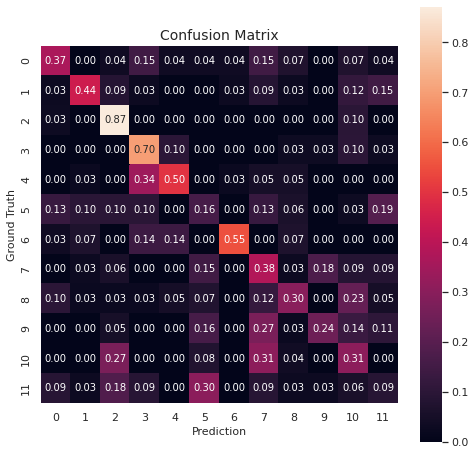

In [ ]:
test_metrics(test_set=testDataset, num_classes=num_classes, backboneEncoder=backboneEncoder_ssl, classificationHead=classificationHead_ssl, crossEntropy=crossEntropy, device=device)

In [ ]:
total_train_loss, total_train_acc, total_val_loss, total_val_acc = supervised_training(train_set=labeledDataset, backboneEncoder=backboneEncoder_sl, classificationHead=classificationHead_sl, 
                                                                                       crossEntropy=crossEntropy, opt=opt, device=device)

Output streaming troncato alle ultime 5000 righe.
[0/1000]:
  - training:      loss=0.003, accuracy=99.914%
  - validation:    loss=0.878, accuracy=81.161%
  - earlyStopping: counter=2, min_loss=0.8783, min_epoch=0

[1/1000]:
  - training:      loss=0.003, accuracy=99.914%
  - validation:    loss=0.878, accuracy=81.164%
  - earlyStopping: counter=1, min_loss=0.8782, min_epoch=1

[2/1000]:
  - training:      loss=0.003, accuracy=99.914%
  - validation:    loss=0.878, accuracy=81.167%
  - earlyStopping: counter=2, min_loss=0.8781, min_epoch=2

[3/1000]:
  - training:      loss=0.003, accuracy=99.914%
  - validation:    loss=0.878, accuracy=81.170%
  - earlyStopping: counter=1, min_loss=0.8779, min_epoch=3

[4/1000]:
  - training:      loss=0.003, accuracy=99.913%
  - validation:    loss=0.878, accuracy=81.173%
  - earlyStopping: counter=2, min_loss=0.8778, min_epoch=4

[5/1000]:
  - training:      loss=0.003, accuracy=99.913%
  - validation:    loss=0.878, accuracy=81.176%
  - earlyStopp

Loss: 10.863512992858887
Accuracy: 0.38717949390411377



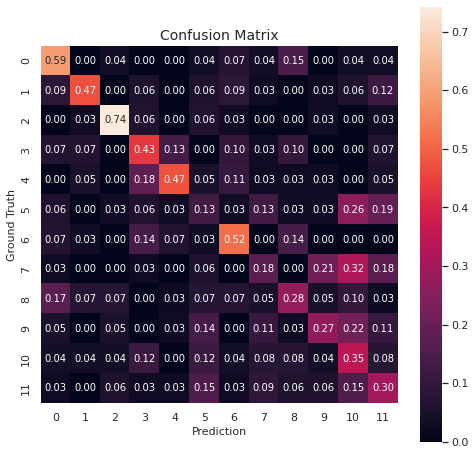

In [ ]:
test_metrics(test_set=testDataset, num_classes=num_classes, backboneEncoder=backboneEncoder_sl, classificationHead=classificationHead_sl, crossEntropy=crossEntropy, device=device)